1. Import and Install Dependencies

In [1]:
%pip install tensorflow tensorflow-gpu opencv-python mediapipe sklearn matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
  Running setup.py install for tensorflow-gpu: started
  Running setup.py install for tensorflow-gpu: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\trush\AppData\Local\Temp\pip-install-awdc28do\tensorflow-gpu_fc3ff67a2ebb492b939b761a009489fe\setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  error: subprocess-e

In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import mediapipe as mp

2. Keypoints using MP Holistic

In [3]:
mp_holistic = mp.solutions.holistic  # This is bringing in the holistic model (used to make detections)
mp_drawing = mp.solutions.drawing_utils # This is bringing in the drawing utilities (used for drawing the detection)

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # color conversion
    image.flags.writeable = False       # image writable status is false 
    results = model.process(image)      # image is the frame from OpenCV, make predictions
    image.flags.writeable = True        # image writeable status is true
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # color conversion back to BGR
    return image, results

In [5]:
# not needed anymore because we have draw_styled_landmarks() NOT NEEDED
# def draw_landmarks(image, results):
#     mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)    # draw face landmarks
#     mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)    # draw pose landmarks
#     mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # draw left hand landmarks
#     mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # draw right hand landmarks

In [6]:
def draw_styled_landmarks(image, results):
    
    # draw face landmarks
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), # color landmarks
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)) # color dots
    
    # draw pose landmarks
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), # color landmarks
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)) # color dots   
    
    # draw left hand landmarks
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), # color landmarks
                              mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)) # color dots 
    
    # draw right hand landmarks
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), # color landmarks
                              mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)) # color dots 

In [7]:
cap = cv2.VideoCapture(0)   # accessing the webcam
# access mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():       # while still accessing the webcam
        ret, frame = cap.read()
        
        # Make detection
        image, results = mediapipe_detection(frame, model=holistic)    # unpack the results
        print(results)

        # Draw landmarks
        draw_styled_landmarks(image, results) 
        
        # Read the feed/frame/image from the webcam with the landmarks in real time
        cv2.imshow('OpenCV Feed', image) # display to screen

        if cv2.waitKey(10) & 0xFF == ord('q'):   # wait for key to be pressed
            break           # when 'q' is pressed terminate the process
    cap.release()
    cv2.destroyAllWindows()            

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [8]:
draw_styled_landmarks(frame, results) # it does not return the image but instead only applies the landmarks to the corrent frame

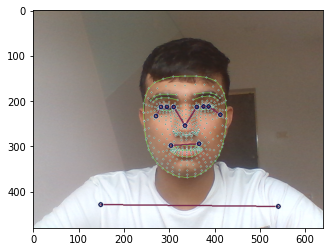

In [9]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

Extract Keypoint Values

In [10]:
results.pose_landmarks

landmark {
  x: 0.5236059427261353
  y: 0.5305938124656677
  z: -1.5781680345535278
  visibility: 0.9996284246444702
}
landmark {
  x: 0.5640950202941895
  y: 0.44388866424560547
  z: -1.4993021488189697
  visibility: 0.9992682337760925
}
landmark {
  x: 0.5878031849861145
  y: 0.44313856959342957
  z: -1.4999758005142212
  visibility: 0.9992555379867554
}
landmark {
  x: 0.6054964065551758
  y: 0.44301578402519226
  z: -1.5002912282943726
  visibility: 0.999121904373169
}
landmark {
  x: 0.4858838617801666
  y: 0.44529467821121216
  z: -1.4924814701080322
  visibility: 0.9992895722389221
}
landmark {
  x: 0.46098342537879944
  y: 0.4448022246360779
  z: -1.4916857481002808
  visibility: 0.9993379712104797
}
landmark {
  x: 0.4420853555202484
  y: 0.44583266973495483
  z: -1.4923425912857056
  visibility: 0.9993756413459778
}
landmark {
  x: 0.6457884311676025
  y: 0.4806727468967438
  z: -0.9283468127250671
  visibility: 0.9992304444313049
}
landmark {
  x: 0.4245770573616028
  y: 0.4

In [11]:
# pose = []
# for res in results.pose_landmarks.landmark:
#     test = np.array([res.x, res.y, res.z, res.visibility])
#     pose.append(test)
#     pose.flatten()
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [12]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [13]:
print(extract_keypoints(results))

[ 0.52360594  0.53059381 -1.57816803 ...  0.          0.
  0.        ]


Setup Folders for Collection

In [32]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('D:\SignLanguageData', 'MP_Data')

# Actions that can be detected
actions = np.array(['hello', 'How are you', 'I love you', 'Good', 'Play'])

# thirty videos worth of data
no_sequence = 30

# Videos will be 30 frames long
sequence_length = 30

In [33]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'hello': 0, 'How are you': 1, 'I love you': 2, 'Good': 3, 'Play': 4}

In [38]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequence):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [18]:
# hello
## 0
## 1
## till
## 29

# thanks
## 0
## 1


In [19]:
# for action in actions:
#     for sequence in range(no_sequence):
#         try:
#             os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
#         except:
#             pass

Data Collection

In [20]:
# cap = cv2.VideoCapture(0)   # accessing the webcam
# # access mediapipe model
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
#     # Loop through actions NEW
#     for action in actions:
#         # Loop through sequence aka videos
#         for sequence in range(no_sequence):
#             # Loop through video length aka sequence length
#             for frame_num in range(sequence_length):
#                 # Read feed
#                 ret, frame = cap.read()
                
#                 # Make detection/unpack the results
#                 image, results = mediapipe_detection(frame, model=holistic)    
#                 print(results)

#                 # Draw landmarks
#                 draw_styled_landmarks(image, results) 

#                 # Apply collection logic NEW
#                 if frame_num == 0:
#                     cv2.putText(image, 'STARTING COLLECTION', (120,200),
#                                 cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 4, cv2.LINE_AA)
#                     cv2.putText(image, 'Collecting frames for {} video number {}'.format(action, sequence), (15,12),
#                                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
#                     cv2.waitKey(2000)
#                 else:
#                     cv2.putText(image, 'Collecting frames for {} video number {}'.format(action, sequence), (15,12),
#                                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)

#                 # NEW Export keypoints
#                 keypoints = extract_keypoints(results)
#                 npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
#                 np.save(npy_path, keypoints)
                
#                 # Read the feed/frame/image from the webcam with the landmarks in real time
#                 cv2.imshow('OpenCV Feed', image) # display to screen

#                 if cv2.waitKey(10) & 0xFF == ord('q'):   # wait for key to be pressed
#                     break           # when 'q' is pressed terminate the process

#     cap.release()
#     cv2.destroyAllWindows()

In [21]:
cap = cv2.VideoCapture(0)
action='Play'
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    counter=0
    # NEW LOOP
    # Loop through actions
    while True:
        # Loop through sequences aka videos
        # os.mkdir(f'C://Users//Yuvraj Sahni//Documents//Test//MP_Data//{action}//{counter}')
        os.makedirs(os.path.join(DATA_PATH, action, str(counter)))
            # Loop through video length aka sequence length
        for frame_num in range(sequence_length):

                # Read feed
            ret, frame = cap.read()

                # Make detections
            image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
            draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
            if frame_num == 0: 
                cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, counter), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                cv2.imshow('OpenCV Feed', image)
                cv2.waitKey(2000)
            else: 
                cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, counter), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
            keypoints = extract_keypoints(results)
            npy_path = os.path.join(DATA_PATH, action , str(counter), str(frame_num))
            np.save(npy_path, keypoints)
            

            #     # Break gracefully
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
        counter+=1
        # if cv2.waitKey(10) & 0xFF == ord('s'):
        #     break
    cap.release()
    cv2.destroyAllWindows()

KeyboardInterrupt: 

In [69]:
cap.release()
cv2.destroyAllWindows()

Preprocess Data and create labels and features

In [23]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [24]:
# #find the number of videos in the folder as we need it to calculate x. For this to run we need to make sure that all the actions that we want have same number of videos
# APP_FOLDER = f'{DATA_PATH}/{action}'
# totalFiles = 0
# totalDir = 0
# for base, dirs, files in os.walk(APP_FOLDER):
#     print('Searching in : ',base)
#     for directories in dirs:
#         totalDir += 1
# print('Total Number of directories',totalDir)

In [39]:
X = np.array(sequences)

In [40]:
X.shape

(150, 30, 1662)

In [41]:
y = to_categorical(labels).astype(int)

In [42]:
y

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0,

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

Making the model

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [45]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [46]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [47]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [54]:
model.fit(X_train, y_train, epochs = 1000, callbacks=[tb_callback])

Epoch 1/1000
5/5 [==============================] - 2s 245ms/step - loss: 1.5023 - categorical_accuracy: 0.3944
Epoch 2/1000
5/5 [==============================] - 1s 271ms/step - loss: 1.4825 - categorical_accuracy: 0.3873
Epoch 3/1000
5/5 [==============================] - 1s 221ms/step - loss: 1.4655 - categorical_accuracy: 0.3310
Epoch 4/1000
5/5 [==============================] - 3s 615ms/step - loss: 1.4037 - categorical_accuracy: 0.4296
Epoch 5/1000
5/5 [==============================] - 1s 263ms/step - loss: 1.3015 - categorical_accuracy: 0.4296
Epoch 6/1000
5/5 [==============================] - 1s 223ms/step - loss: 1.2072 - categorical_accuracy: 0.4648
Epoch 7/1000
5/5 [==============================] - 1s 237ms/step - loss: 1.1439 - categorical_accuracy: 0.5070
Epoch 8/1000
5/5 [==============================] - 1s 210ms/step - loss: 1.1357 - categorical_accuracy: 0.4930
Epoch 9/1000
5/5 [==============================] - 1s 192ms/step - loss: 1.0713 - categorical_accuracy:

KeyboardInterrupt: 

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 598,981
Trainable params: 598,981
Non-trai

Make Predictions

In [56]:
res = model.predict(X_test)

1/1 [==============================] - 1s 967ms/step


In [57]:
actions[np.argmax((res[2]))]

'hello'

In [58]:
actions[np.argmax(y_test[2])]

'hello'

Save Weights

In [59]:
model.save('action.h5')

In [ ]:
del model

In [60]:
model.load_weights('action.h5')

Confusion Matrix

In [61]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [62]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 79ms/step


In [63]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [64]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[4, 0],
        [0, 4]],

       [[6, 0],
        [0, 2]],

       [[6, 0],
        [0, 2]]], dtype=int64)

In [65]:
accuracy_score(ytrue, yhat)

1.0

Test in real time

In [66]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [75]:
# Run at last
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, cv2.cvtColor(image, cv2.COLOR_BGR2RGB), colors))


IndexError: list index out of range

<Figure size 1296x1296 with 0 Axes>

In [76]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
        
         #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

IndexError: list index out of range

In [74]:
sentence

['hello', 'I love you', 'Good', 'Play', 'Good']

In [ ]:
import pyttsx3

text_speech=pyttsx3.init()

counter=0

while counter<len(sentence):
    answer=sentence[counter]
    text_speech.say(answer)
    counter+=1
    text_speech.runAndWait()

In [ ]:
cap.release()
cv2.destroyAllWindows()

In [ ]:
res[np.argmax(res)] > threshold

In [ ]:
model.predict(np.expand_dims(X_test[0], axis=0))